In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from mmseg.models.losses.cross_entropy_loss import cross_entropy

/media/soft/mzm/miniconda3/envs/wsss_mmseg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cam = np.load('/media/ders/mazhiming/mmseg4wsss/mmsegmentation/save_npy/cam.npy')
depth_maps = np.load('/media/ders/mazhiming/mmseg4wsss/mmsegmentation/save_npy/depth_maps.npy')
labels = np.load('/media/ders/mazhiming/mmseg4wsss/mmsegmentation/save_npy/label.npy')
sal = np.load('/media/ders/mazhiming/mmseg4wsss/mmsegmentation/save_npy/sal.npy')

In [3]:
cam_tensor = torch.from_numpy(cam)
roll_cam_tensor = torch.roll(cam_tensor,shifts=1,dims=1)

depth_maps_tensor = torch.from_numpy(depth_maps)
labels_tensor = torch.from_numpy(labels)
sal_tensor = torch.from_numpy(sal)
b,h,w = labels.shape
roll_cam_tensor = F.interpolate(roll_cam_tensor,size=(h,w),mode='bilinear',align_corners=True)

In [4]:
cam_labels_ce_loss = cross_entropy(roll_cam_tensor,labels_tensor,ignore_index=255)
cam_labels_ce_loss

tensor(0.7968)

In [5]:
# roll_cam_tensor.size()
# >>> (8, 21, 448, 448)

# labels_tensor.size()
# >>> (8, 448, 448)

# depth_maps_tensor.size()
# >>> (8, 1, 448, 448)

reshape_depth_maps_tensor = depth_maps_tensor.view(8,448,448)

In [6]:
reshape_depth_maps_tensor = reshape_depth_maps_tensor.long()

In [7]:
# 提取labels_tensor的元素集合
labels_tensor_set = torch.unique(labels_tensor[1])

# 提取depth_maps_tensor的元素集合
depth_maps_tensor_set = torch.unique(reshape_depth_maps_tensor[1])

print(labels_tensor_set)
print()
print(depth_maps_tensor_set)

tensor([  0,   7,  15, 255])

tensor([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,  14,  15,
         17,  18,  19,  20,  22,  23,  25,  26,  27,  29,  30,  32,  33,  34,
         35,  37,  38,  39,  41,  42,  43,  44,  45,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
         96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
        110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
        124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
        138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149, 150, 152, 153,
        154, 156, 157, 158, 160, 161, 162, 164, 165, 166, 168, 169, 171, 172,
        174, 175, 177, 178, 180, 181, 183, 185, 186, 188, 189, 191, 193, 195,
        197, 199, 201, 203, 205, 2

```python
def get_class_forground(cam, depth_t, cam_thr=0.2, score_thr=0.3):
    cam[cam > cam_thr] = 1
    cam[cam <= cam_thr] = 0

    classes_forgoundmap = torch.zeros_like(cam)
    
    c, h, w = depth_t.shape
    depth_t_i = depth_t.clone()
    for i in range(c):
        depth_t_i[i, ...] = depth_t[i, ...] * cam
        sum_depth_i = torch.sum(depth_t_i[i, ...])
        score = sum_depth_i / torch.sum(depth_t[i, ...])
        if score > score_thr:
            classes_forgoundmap += depth_t[i, ...]

    return classes_forgoundmap
```

一种点乘的方法

In [22]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# 方差卷积核
var_kernel = torch.Tensor([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]
]).view(1, 1, 3, 3)
var_kernel = var_kernel.repeat(1, 1, 1, 1)
# var_kernel = var_kernel.long()

def get_refined_cam_by_depth(cam_tensor,depth_tensor):
    """
    cam_tensor: (21,448,448)
    depth_tensor: (448,448)
    """
    # 假设你的深度图张量名为depth_tensor，它的形状为[448, 448]
    # 调整深度图的形状以适应卷积
    depth_tensor_padded = depth_tensor.unsqueeze(0).unsqueeze(0).float()
    # depth_tensor_padded = depth_tensor_padded.long()
    # 使用卷积计算方差
    var_map = F.conv2d(depth_tensor_padded, var_kernel, padding=1)
    var_map = var_map.squeeze().abs()

    # 将方差映射调整为与cam_tensor相同的形状
    var_map = F.interpolate(var_map.unsqueeze(0).unsqueeze(0), size=cam_tensor.shape[1:], mode='bilinear', align_corners=True)
    # 将方差映射归一化为0-1
    var_map = var_map / var_map.max()

    # 将cam_tensor与方差相乘
    cam_tensor = cam_tensor * var_map
    return cam_tensor

In [24]:
def make_pse_mask(cam,thr):
    cam=F.sigmoid(cam)
    cam[0,...]=thr
    pse_mask=torch.argmax(cam,dim=0)
    return pse_mask

In [30]:
refined_cam_tensors = roll_cam_tensor.clone()
for i in range(roll_cam_tensor.size()[0]):
    refined_cam_tensors[i] = get_refined_cam_by_depth(roll_cam_tensor[i],reshape_depth_maps_tensor[i])

In [31]:
refined_cam_labels_ce_loss = cross_entropy(refined_cam_tensors, labels_tensor, ignore_index=255)
refined_cam_labels_ce_loss

tensor(2.2608)

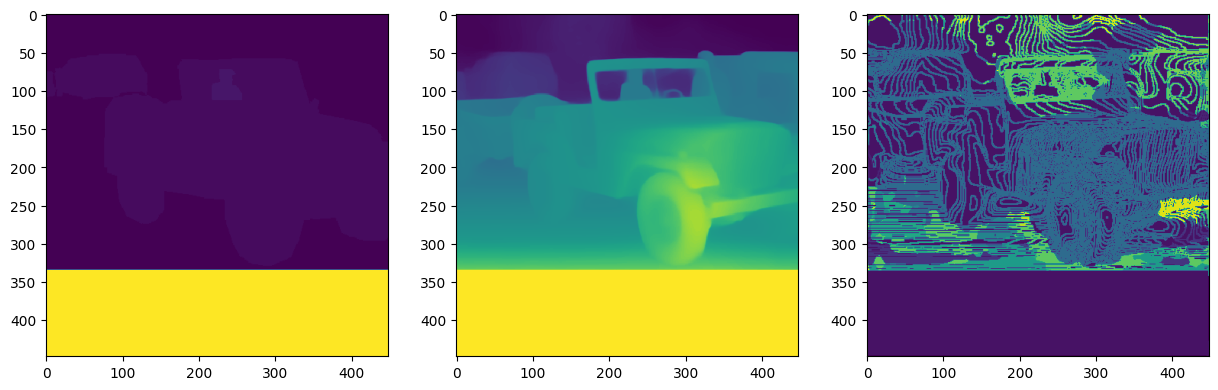

In [33]:
# 可视化
show_labels = labels_tensor[1].numpy()
show_depth_maps = reshape_depth_maps_tensor[1].numpy()
show_pse_mask = make_pse_mask(refined_cam_tensors[1],0.3).numpy()

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(show_labels)

axs[1].imshow(show_depth_maps)

axs[2].imshow(show_pse_mask)

In [ ]:
cam_depth_maps_ce_loss = cross_entropy(roll_cam_tensor,reshape_depth_maps_tensor,ignore_index=255)
cam_depth_maps_ce_loss

IndexError: Target 80 is out of bounds.